## SilkMoth Demo

### Related Set Discovery task under Set‑Containment using Jaccard Similarity

Import of all required modules:

In [1]:
import sys
sys.path.append("src")

from silkmoth.tokenizer import Tokenizer
from silkmoth.inverted_index import InvertedIndex
from silkmoth.signature_generator import SignatureGenerator
from silkmoth.candidate_selector import CandidateSelector
from silkmoth.verifier import Verifier
from silkmoth.silkmoth_engine import SilkMothEngine


from silkmoth.utils import jaccard_similarity, contain, edit_similarity, similar, SigType

import matplotlib.pyplot as plt
from IPython.display import display, Markdown

import numpy as np
import pandas as pd

Define example related dataset from "SilkMoth" paper (reference set **R** and source sets **S**)


In [2]:
# Location Dataset
reference_set = [
    '77 Mass Ave Boston MA',
    '5th St 02115 Seattle WA',
    '77 5th St Chicago IL'
]

# Address Dataset
source_sets = [
    ['Mass Ave St Boston 02115','77 Mass 5th St Boston','77 Mass Ave 5th 02115'],
    ['77 Boston MA','77 5th St Boston 02115','77 Mass Ave 02115 Seattle'],
    ['77 Mass Ave 5th Boston MA','Mass Ave Chicago IL','77 Mass Ave St'],
    ['77 Mass Ave MA','5th St 02115 Seattle WA','77 5th St Boston Seattle']
]

# thresholds & q
δ = 0.7
α = 0.0
q = 3

display(Markdown("**Reference set (R):**"))
for i, r in enumerate(reference_set):
    display(Markdown(f"- R[{i}]: “{r}”"))
display(Markdown("**Source sets (S):**"))
for j, S in enumerate(source_sets):
    display(Markdown(f"- S[{j}]: “{' | '.join(S)}”"))

**Reference set (R):**

- R[0]: “77 Mass Ave Boston MA”

- R[1]: “5th St 02115 Seattle WA”

- R[2]: “77 5th St Chicago IL”

**Source sets (S):**

- S[0]: “Mass Ave St Boston 02115 | 77 Mass 5th St Boston | 77 Mass Ave 5th 02115”

- S[1]: “77 Boston MA | 77 5th St Boston 02115 | 77 Mass Ave 02115 Seattle”

- S[2]: “77 Mass Ave 5th Boston MA | Mass Ave Chicago IL | 77 Mass Ave St”

- S[3]: “77 Mass Ave MA | 5th St 02115 Seattle WA | 77 5th St Boston Seattle”

### 1. Tokenization
Tokenize each element of R and each S using Jaccard Similarity (whitespace tokens)


In [3]:
tokenizer = Tokenizer(jaccard_similarity, q)
tokenized_R = tokenizer.tokenize(reference_set)
tokenized_S = [tokenizer.tokenize(S) for S in source_sets]

display(Markdown("**Tokenized Reference set (R):**"))
for i, toks in enumerate(tokenized_R):
    display(Markdown(f"- Tokens of R[{i}]: {toks}"))

display(Markdown("**Tokenized Source sets (S):**"))
for i, toks in enumerate(tokenized_S):
    display(Markdown(f"- Tokens of S[{i}]: {toks}"))

**Tokenized Reference set (R):**

- Tokens of R[0]: {'Mass', 'Boston', 'MA', '77', 'Ave'}

- Tokens of R[1]: {'02115', 'WA', 'Seattle', 'St', '5th'}

- Tokens of R[2]: {'Chicago', 'IL', 'St', '5th', '77'}

**Tokenized Source sets (S):**

- Tokens of S[0]: [{'02115', 'Mass', 'Boston', 'St', 'Ave'}, {'Mass', 'Boston', 'St', '5th', '77'}, {'02115', 'Mass', '5th', '77', 'Ave'}]

- Tokens of S[1]: [{'MA', 'Boston', '77'}, {'02115', 'Boston', 'St', '5th', '77'}, {'02115', 'Mass', 'Seattle', '77', 'Ave'}]

- Tokens of S[2]: [{'Mass', 'Boston', '5th', 'MA', '77', 'Ave'}, {'IL', 'Chicago', 'Mass', 'Ave'}, {'77', 'Mass', 'St', 'Ave'}]

- Tokens of S[3]: [{'MA', '77', 'Mass', 'Ave'}, {'02115', 'WA', 'Seattle', 'St', '5th'}, {'Boston', 'Seattle', 'St', '5th', '77'}]

### 2. Build Inverted Index
Builds an inverted index on the tokenized source sets and shows an example lookup.

In [4]:
index = InvertedIndex(tokenized_S)
display(Markdown(f"- Index built over {len(source_sets)} source sets."))
display(Markdown(f"- Example: token “Mass” appears in → {index.get_indexes('Mass')}"))


- Index built over 4 source sets.

- Example: token “Mass” appears in → [(0, 0), (0, 1), (0, 2), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0)]

### 3. Signature Generation

Generates the weighted signature for R given δ, α (here α=0), using Jaccard Similarity.

In [5]:
sig_gen = SignatureGenerator()
signature = sig_gen.get_signature(
    tokenized_R, index,
    delta=δ, alpha=α,
    sig_type=SigType.WEIGHTED,
    sim_fun=jaccard_similarity,
    q=q
)
display(Markdown(f"- Selected signature tokens: **{signature}**"))

- Selected signature tokens: **['Chicago', 'WA', 'IL', '5th']**

### 4. Initial Candidate Selection

Looks up each signature token in the inverted index to form the candidate set.


In [6]:
cand_sel = CandidateSelector(
    similarity_func=jaccard_similarity,
    sim_metric=contain,
    related_thresh=δ,
    sim_thresh=α,
    q=q
)

initial_cands = cand_sel.get_candidates(signature, index, len(tokenized_R))
display(Markdown(f"- Candidate set indices: **{sorted(initial_cands)}**"))
for j in sorted(initial_cands):
    display(Markdown(f"  - S[{j}]: “{' | '.join(source_sets[j])}”"))

- Candidate set indices: **[0, 1, 2, 3]**

  - S[0]: “Mass Ave St Boston 02115 | 77 Mass 5th St Boston | 77 Mass Ave 5th 02115”

  - S[1]: “77 Boston MA | 77 5th St Boston 02115 | 77 Mass Ave 02115 Seattle”

  - S[2]: “77 Mass Ave 5th Boston MA | Mass Ave Chicago IL | 77 Mass Ave St”

  - S[3]: “77 Mass Ave MA | 5th St 02115 Seattle WA | 77 5th St Boston Seattle”

### 5. Check Filter
Prunes candidates by ensuring each matched element passes the local similarity bound.


In [11]:
filtered_cands, match_map = cand_sel.check_filter(
    tokenized_R, set(signature), initial_cands, index
)
display(Markdown(f"**Surviving after check filter:** **{sorted(filtered_cands)}**"))
for j in sorted(filtered_cands):
    display(Markdown(f"S[{j}] matched:"))
    for r_idx, sim in match_map[j].items():
        sim_text = f"{sim:.3f}"
        display(Markdown(f"     • R[{r_idx}] “{reference_set[r_idx]}” → sim = {sim_text}"))
    
    matches = match_map.get(j, {})
    if matches:
        best_sim = max(matches.values())
        num_matches = len(matches)
        display(Markdown(f"  → Best sim: **{best_sim:.3f}** | Matched elements: **{num_matches}**"))
    else:
        display(Markdown(f"No elements passed similarity checks."))


**Surviving after check filter:** **[0, 1, 3]**

S[0] matched:

     • R[2] “77 5th St Chicago IL” → sim = 0.429

  → Best sim: **0.429** | Matched elements: **1**

S[1] matched:

     • R[2] “77 5th St Chicago IL” → sim = 0.429

  → Best sim: **0.429** | Matched elements: **1**

S[3] matched:

     • R[1] “5th St 02115 Seattle WA” → sim = 1.000

     • R[2] “77 5th St Chicago IL” → sim = 0.429

  → Best sim: **1.000** | Matched elements: **2**

### 6. Nearest‑Neighbor Filter

Further prunes via nearest‑neighbor upper bounds on total matching score.


In [8]:
nn_filtered = cand_sel.nn_filter(
    tokenized_R, set(signature), filtered_cands,
    index, threshold=δ, match_map=match_map
)
display(Markdown(f"- Surviving after NN filter: **{sorted(nn_filtered)}**"))
for j in nn_filtered:
    display(Markdown(f"  - S[{j}]: “{' | '.join(source_sets[j])}”"))


- Surviving after NN filter: **[3]**

  - S[3]: “77 Mass Ave MA | 5th St 02115 Seattle WA | 77 5th St Boston Seattle”

### 7. Verification

Runs the bipartite max‑matching on the remaining candidates and outputs the final related sets.


In [16]:
verifier = Verifier(δ, contain, jaccard_similarity, sim_thresh=α, reduction=False)
results = verifier.get_related_sets(tokenized_R, nn_filtered, index)

if results:
    display(Markdown(f"Final related sets (score ≥ {δ}):"))
    for j, score in results:
        display(Markdown(f"  • S[{j}]: “{' | '.join(source_sets[j])}” → **{score:.3f}**"))
else:
    display(Markdown("- No sets passed verification."))


Final related sets (score ≥ 0.7):

  • S[3]: “77 Mass Ave MA | 5th St 02115 Seattle WA | 77 5th St Boston Seattle” → **0.743**

### Comparison of Containment metric: Jaccard vs Edit
Fixes the relatedness metric to CONTAINMENT (δ=0.7), then runs two engines:
- Jaccard / contain (with all filters on)  
- Edit /   contain (filters off) 

/Users/aminaiqbal/Desktop/LSDI Project/LSDIPro-SilkMoth/src/silkmoth/signature_generator.py:69: UserWarning: q=3 is too large for delta = 0.700; no valid weighted signature exists -> falling back to brute-force.
  warnings.warn(


### Containment Scores: Jaccard vs Edit

,Jaccard‑contain,Edit‑contain
Source Set,,
3,0.743,0.728


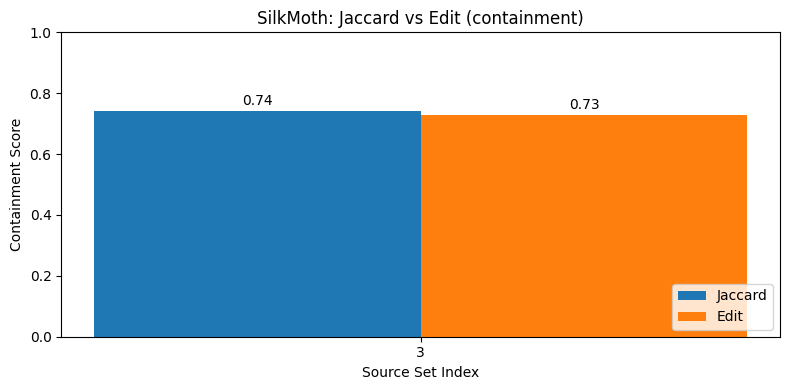

In [ ]:
#Leave out for now

# 1) Jaccard + SET‑CONTAINMENT (filters)
engine_jac = SilkMothEngine(
    related_thresh=0.7,
    source_sets=source_sets,
    sim_metric=contain,
    sim_func=jaccard_similarity,
    sim_thresh=0.0,
    reduction=False,
    sig_type=SigType.WEIGHTED,
    is_check_filter=True,
    is_nn_filter=True,
    q=3
)
res_jac, _, _ = engine_jac.search_sets(reference_set)
jac = {idx: score for idx,score in res_jac}

# 2) Edit + SET‑CONTAINMENT (no filters)
engine_edit = SilkMothEngine(
    related_thresh=0.7,
    source_sets=source_sets,
    sim_metric=contain,
    sim_func=edit_similarity,
    sim_thresh=0.0,
    reduction=True,
    sig_type=SigType.WEIGHTED,
    is_check_filter=False,
    is_nn_filter=False,
    q=3
)
res_edit, _, _ = engine_edit.search_sets(reference_set)
eds = {idx: score for idx,score in res_edit}

# 3) Build DataFrame
all_idx = sorted(set(jac)|set(eds))
df = pd.DataFrame({
    'Jaccard‑contain': [ jac.get(i,0.0) for i in all_idx ],
    'Edit‑contain':    [ eds.get(i, 0.0) for i in all_idx ],
}, index=all_idx)
df.index.name = 'Source Set'

display(Markdown("### Containment Scores: Jaccard vs Edit"))
display(df.style.format("{:.3f}"))

# 4) Plot grouped bar chart
x     = np.arange(len(all_idx))
width = 0.35

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(x-width/2, df['Jaccard‑contain'], width, label='Jaccard')
ax.bar(x+width/2, df['Edit‑contain'],    width, label='Edit')
ax.set_xticks(x); ax.set_xticklabels(all_idx)
ax.set_xlabel('Source Set Index')
ax.set_ylabel('Containment Score')
ax.set_title('SilkMoth: Jaccard vs Edit (containment)')
ax.set_ylim(0,1.0)
ax.legend(loc='lower right')

for xi in x:
    ax.text(xi-width/2, df.iloc[xi,0]+0.02, f"{df.iloc[xi,0]:.2f}", ha='center')
    ax.text(xi+width/2, df.iloc[xi,1]+0.02, f"{df.iloc[xi,1]:.2f}", ha='center')

plt.tight_layout()
plt.show()